# MNIST KNN Classifier
### Abinash Patti

## Fetching Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset from OpenML, as_frame=False returns data as numpy arrays
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

# View the keys
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


## Data Preprocessing and Splitting

In [6]:
# Assign data and target and convert labels to integers (they are string by default)
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Slice data for training set and testing set (60,000:10,000 train/test)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## Baseline Model Training


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize a default KNN classifier
knn_clf = KNeighborsClassifier()

# Fit the model on the training set
knn_clf.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = knn_clf.predict(X_test)

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy: ", baseline_accuracy)

Baseline Accuracy:  0.9688


## Hyperparameter Tuning
Perform a grid search optimization to identify the optimal hyperparameters for the `KNeighborsClassifier`.
Target parameters:
- `weights`: Compare uniform vs. distance-based weighting.
- `n_neighbors`: Evaluate sensitivity to neighbor count (k).

Utilize 3-fold cross-validation to validate generalization performance during the search.

In [9]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid
param_grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3,4,5]}

# New base model
knn_clf = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=-1)

# Execute search
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Abinash\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.96818333        nan 0.96663333        nan 0.96741667 0.9686    ]
  warnings.warn(


,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


## Hyperparameter Analysis
Extract and inspect the optimal hyperparameters identified by the grid search. Review the best cross-validation score to verify improvement over the baseline.

In [12]:
# Get the best combination of parameters
print(grid_search.best_params_)

# Get the best accuracy
print(grid_search.best_score_)

# Isolate best estimator (this model is the one trained with best parameters)
knn_clf_final = grid_search.best_estimator_

{'n_neighbors': 5, 'weights': 'distance'}
0.9686


## Final Model Evaluation
Assess the generalization performance of the optimized model using the test set (10,000 samples).

In [13]:
# Predict on test set
y_pred_final = knn_clf_final.predict(X_test)

# Calculate accuracy
accuracy_score_final = accuracy_score(y_test, y_pred_final)

# Print final accuracy
print("Final accuracy", accuracy_score_final)

Final accuracy 0.9691


The model hasn't yet reached the goal of 97% here. Unlucky.

## Manual Fine-Tuning
Try to decrease bias and capture finer local decision boundaries by using `4` for `n_neighbors`

In [15]:
# Another model
knn_clf_final_4_neighbors = KNeighborsClassifier()

# Fit training set on new model
knn_clf_final_4_neighbors.fit(X_train, y_train)

# Predict on test set
y_pred_final_4_neighbors = knn_clf_final_4_neighbors.predict(X_test)

# Evaluate accuracy
accuracy_score_final_4_neighbors = accuracy_score(y_test, y_pred_final_4_neighbors)

# Print accuracy
print(accuracy_score_final_4_neighbors)

0.9688


Yeah I don't know why I thought 4 would work better than the optimized hyperparameters provided by the `grid_search`. Online some people say 4 works best for MNIST but not for me here. Seems I've reached a plateau just shy of 97% accuracy.

## Data Augmentation

**Strategy:**
1. Define a utility function to shift images by 1 pixel.
2. Generate 4 shifted copies (Up, Down, Left, Right) for every training image.
3. Train the best model configuration on this expanded dataset.

In [20]:
from scipy.ndimage import shift

# Define a helper function
def shift_image(image, vector):
    # Reshape image to 28x28
    img_2d = image.reshape(28,28)

    # Use scipy's shift function
    shifted_2d = shift(img_2d, vector, cval=0, mode="constant")

    # Flatten shifted image
    return shifted_2d.flatten()

# Initialize lists with original training set
X_augmented = [x for x in X_train]
y_augmented = [y for y in y_train]

# Define shift directions
[down, up, right, left] = ((1,0), (-1,0), (0,1), (0,-1))

# For each image, label 
for (image, label) in zip(X_train, y_train):
    # For each dy, dx in shift directions
    for vector in (down, up, right, left):
        # Create shifted image
        shifted_image = shift_image(image, vector)
        # Append to augmented dataset
        X_augmented.append(shifted_image)
        y_augmented.append(label)

# Convert back to numpy arrays
X_train_aug = np.array(X_augmented)
y_train_aug = np.array(y_augmented)

# Shuffle the augmented dataset
shuffle_idx = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[shuffle_idx]
y_train_aug = y_train_aug[shuffle_idx]



Now there are 300,000 images in the training set: 60,000 original, and 60,000 shifted one pixel in each direction (up, down, left, right).

## Final Model Training (Augmented Data)
Train the model with optimal hyperparameters as provided by `grid_search` and evaluate performance on the original, un-augmented test set

In [21]:
# knn_clf_final is the model/estimator with the optimal parameters

# Fit final model on augmented training set
knn_clf_final.fit(X_train_aug, y_train_aug)

# Generate final predictions
y_pred_final_aug = knn_clf_final.predict(X_test)

# Calculate final accuracy score
accuracy_score_final_aug = accuracy_score(y_test, y_pred_final_aug)

# Print final accuracy score
print("Accuracy score: ", accuracy_score_final_aug)

Accuracy score:  0.9766


## Error Analysis
Accuracy tells us *how many* we got right, but not *what* we got wrong.
We will visualize the **Confusion Matrix** to see where the model is struggling.

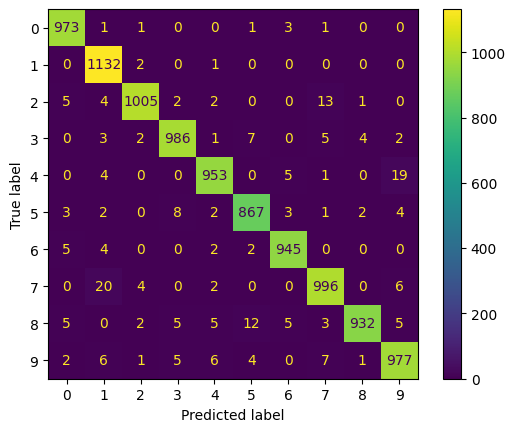

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_final_aug)

# Visualize/plot confusion matrix
ConfusionMatrixDisplay(cm).plot()
plt.show()

The confusion matrix looks quite good, but I can see a few misclassifications. The model classifies some 4s as 9s, some 7s as 2s. This is understandable since they look very similar to us in writing and even humans would make the same classification errors most of the time.